Code from here: https://twiecki.io/blog/2015/11/10/mcmc-sampling/

In [334]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm, binom, dirichlet, bernoulli, beta

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [2]:
data = np.random.randn(20)

/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


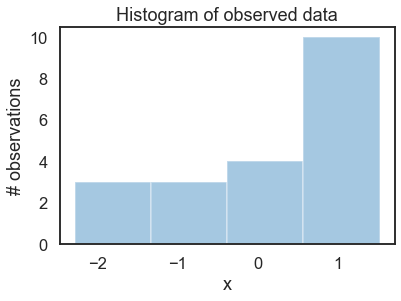

In [86]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

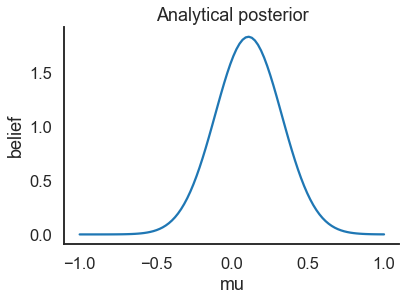

In [13]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 100)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

MCMC

In [102]:
mu_current = 1.
proposal_width = 0.1

mu_proposal = norm(mu_current, proposal_width).rvs()

In [103]:
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

In [107]:
prior_current = norm(0., 1.).pdf(mu_current)
prior_proposal = norm(0., 1.).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

In [313]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.2, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future vers

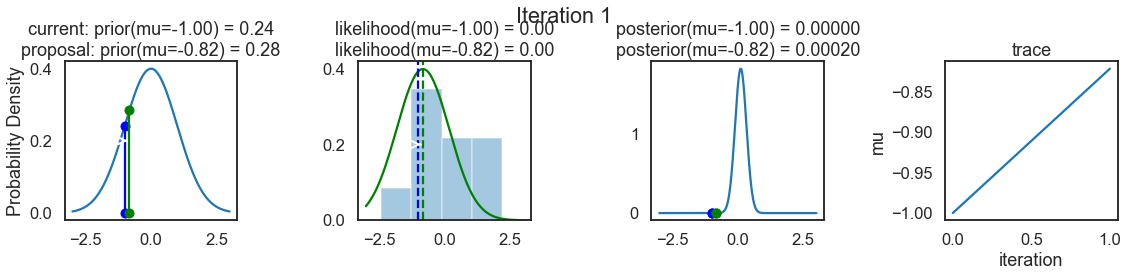

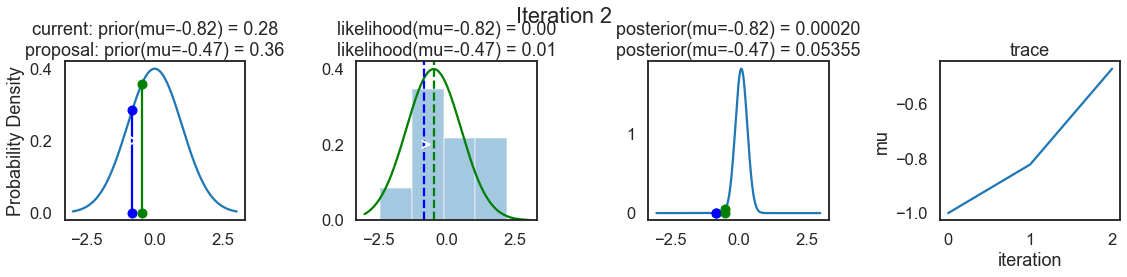

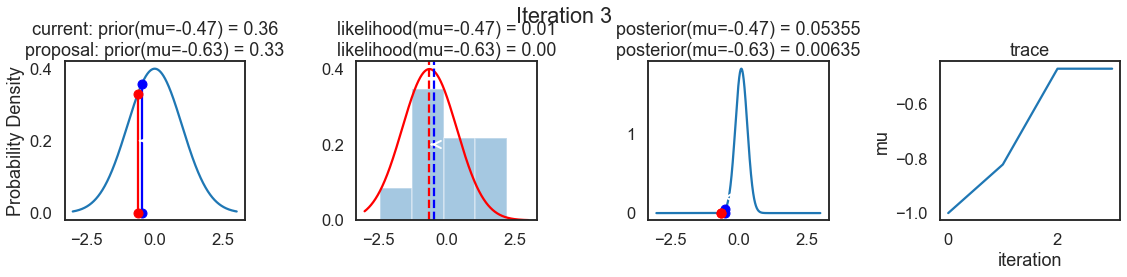

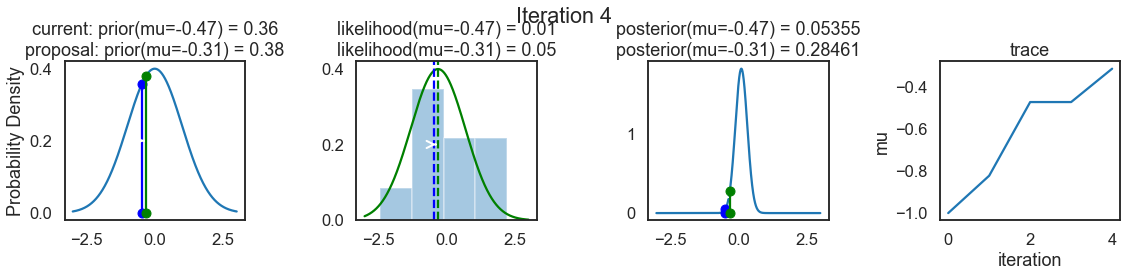

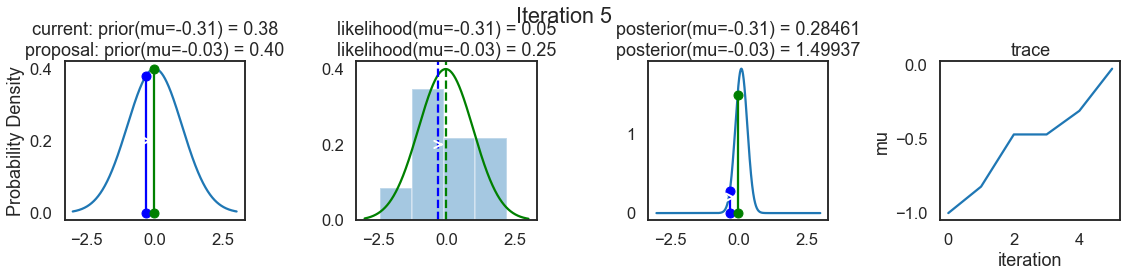

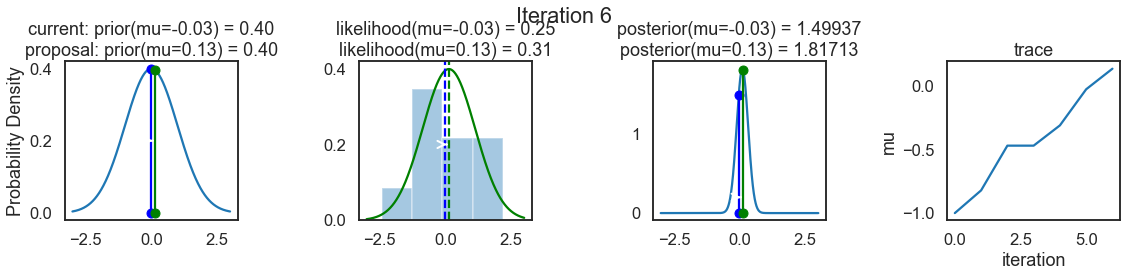

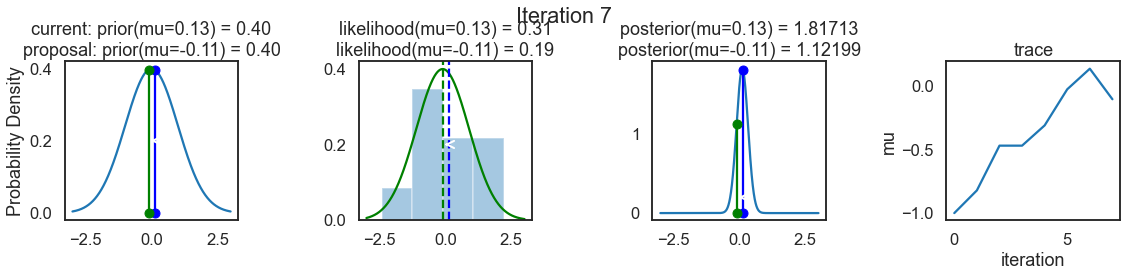

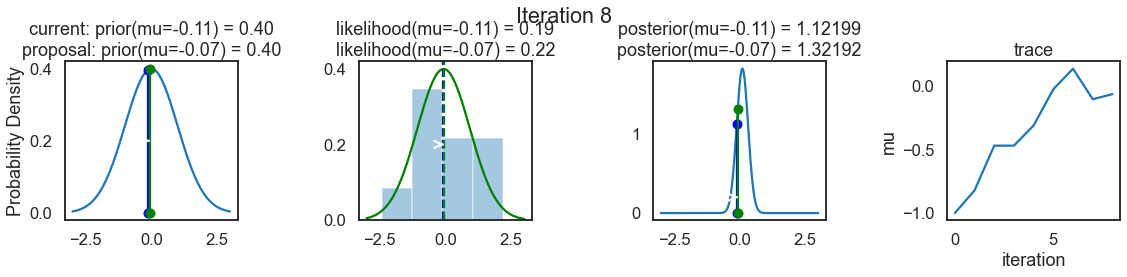

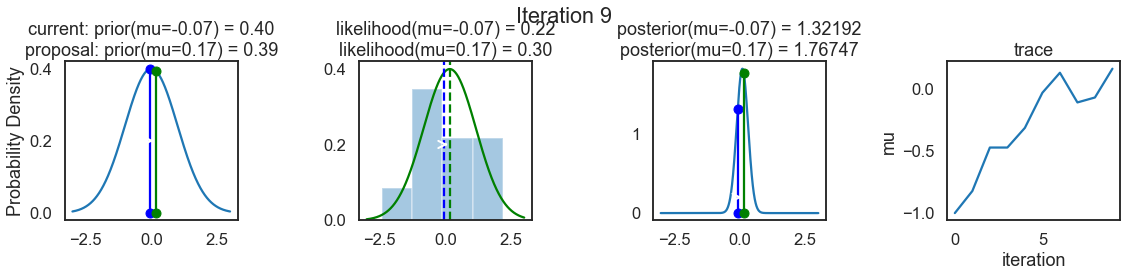

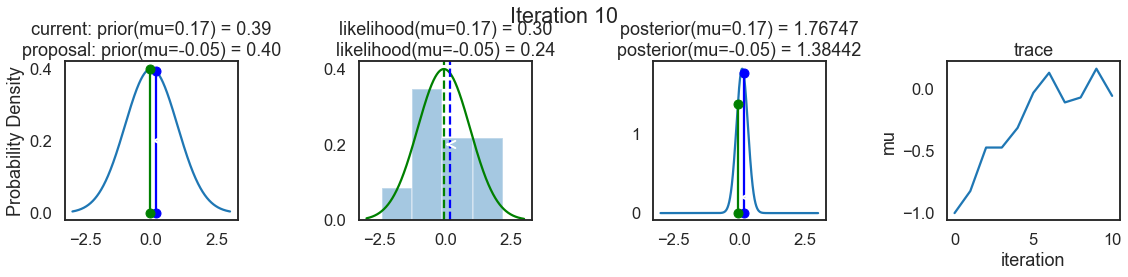

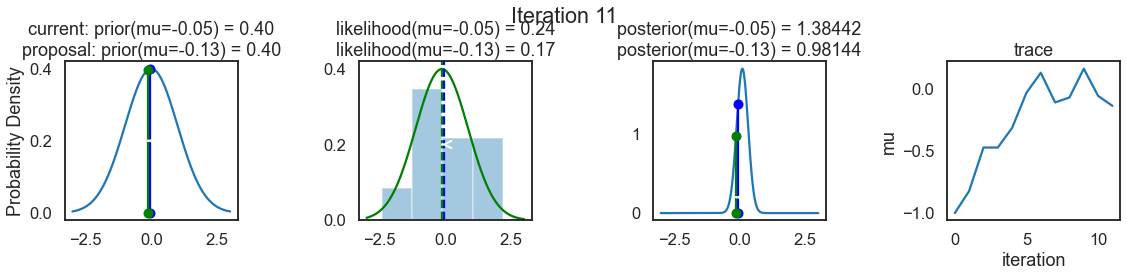

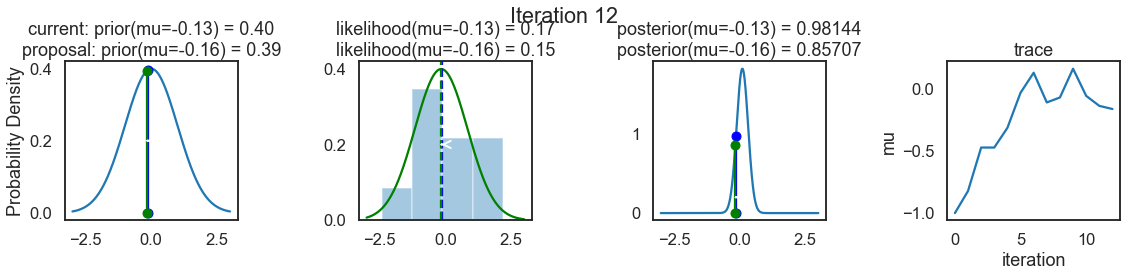

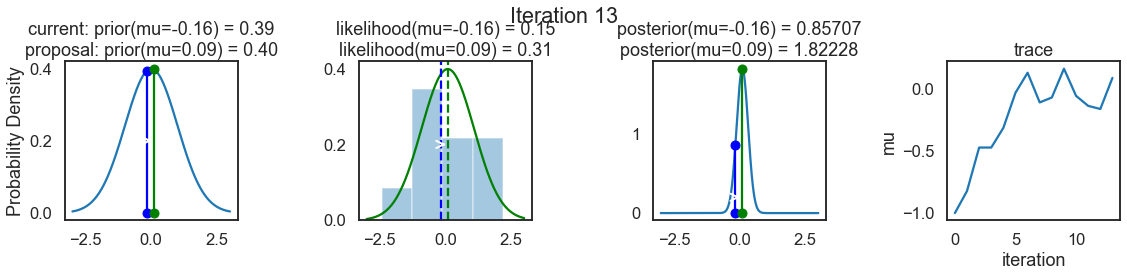

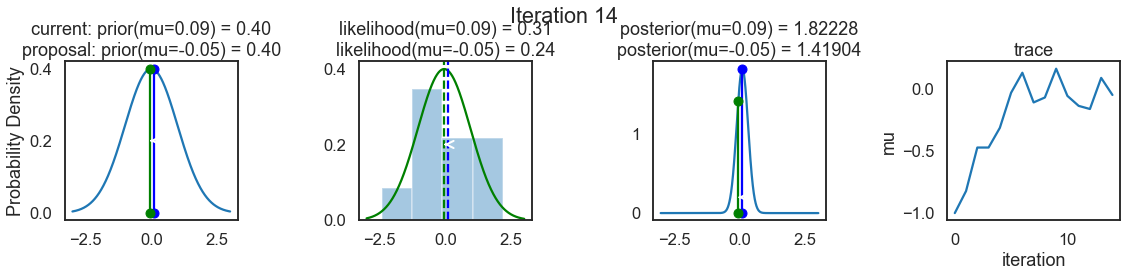

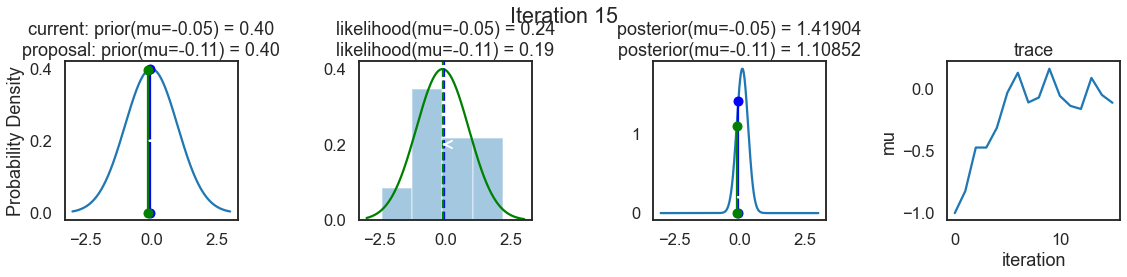

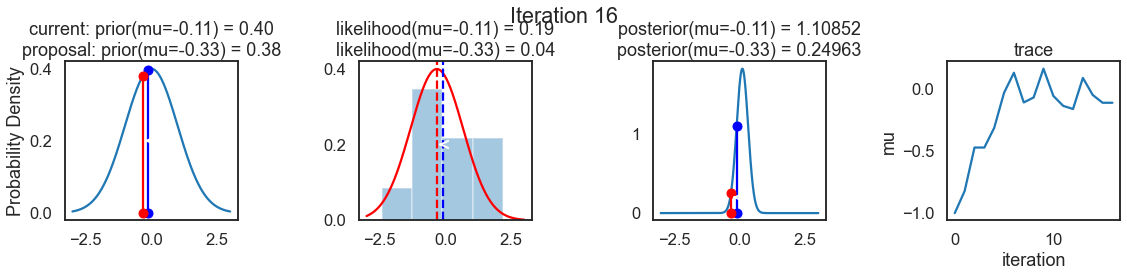

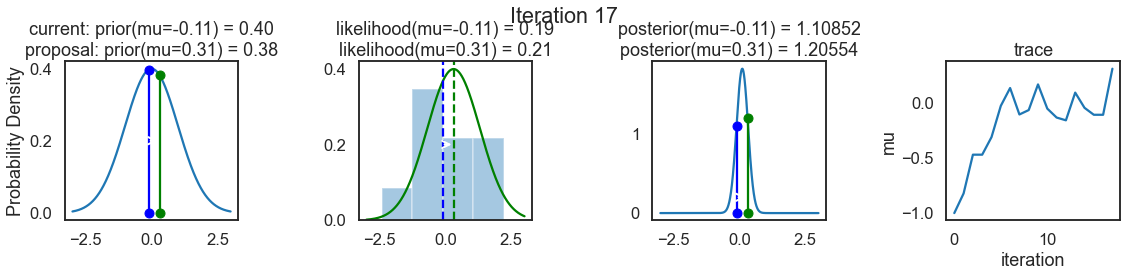

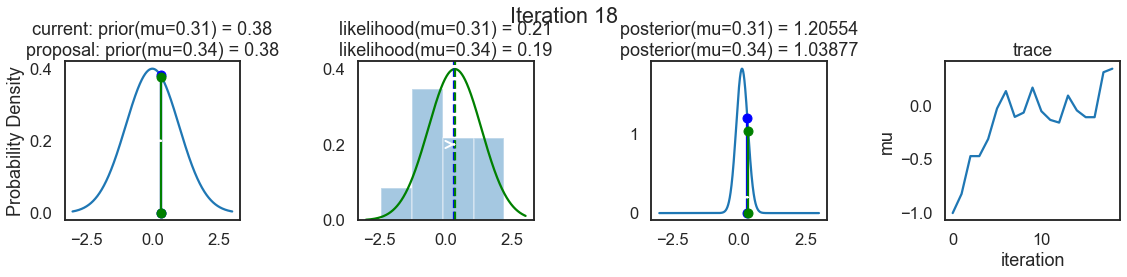

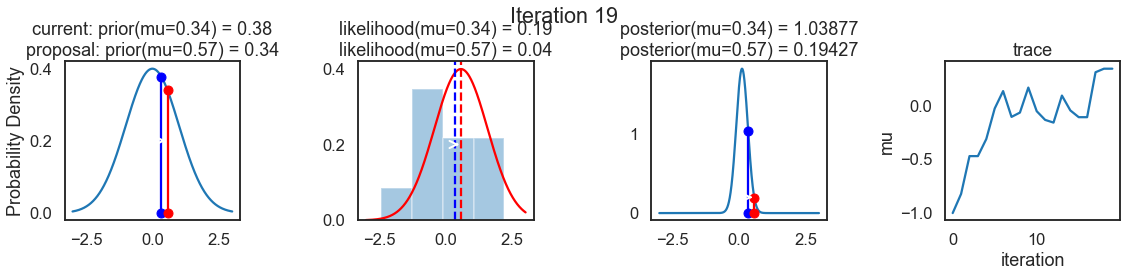

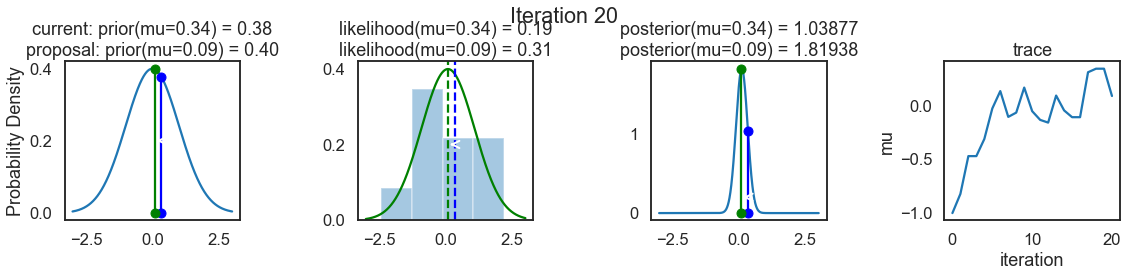

In [12]:
x = sampler(data, samples=20, mu_init=-1., plot=True)

#TODO: Write sampler for binomial

In [316]:
n = 1000
data = np.random.binomial(1, 0.5, 1000) 

In [206]:
(unique, counts) = np.unique(data, return_counts=True)

In [372]:
prior = beta(a=1, b=2)
likelihood = bernoulli(0.5)
posterior = beta(a=503, b=503)

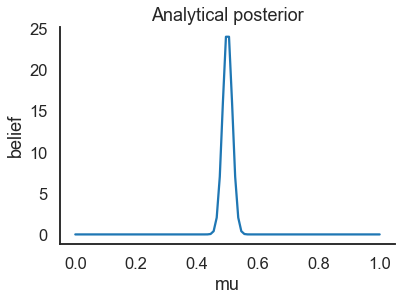

In [375]:
ax = plt.subplot()
x = np.linspace(0, 1, 100)
posterior_analytical = [posterior.pdf(xx) for xx in x]
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [407]:
def sampler_bernoulli(n_trials, k_success, samples=4, p_init=.5, proposal_width=.2, plot=False, p_prior_a=2., p_prior_b=2.):
    p_current = p_init
    posterior = [p_current]
    for i in range(samples):
        # suggest new position
        p_proposal = norm(p_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = binom.pmf(k_success, n_trials, p_current)
        likelihood_proposal = binom.pmf(k_success, n_trials, p_proposal)
        
        # Compute prior probability of current and proposed mu        
        prior_current = beta(a=p_prior_a, b=p_prior_b).pdf(p_current)
        prior_proposal = beta(a=p_prior_a, b=p_prior_b).pdf(p_proposal)
        
        posterior_current = likelihood_current * prior_current
        posterior_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        posterior_accept = posterior_proposal / posterior_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < posterior_accept
        
        if accept:
            # Update position
            p_current = p_proposal
        
        posterior.append(p_current)
        
    return np.array(posterior)

In [408]:
res = sampler_bernoulli(100, 10, samples=5000, p_prior_a=1, p_prior_b=1)

/Users/Tamas.Jambor@kindredgroup.com/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


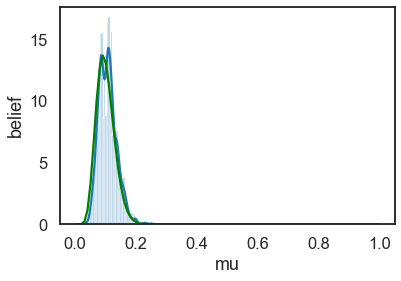

In [409]:
ax = plt.subplot()

sns.distplot(res[500:], ax=ax, label='estimated posterior')
x = np.linspace(0, 1, 100)
post = beta(a=10, b=90)
posterior_analytical = [post.pdf(xx) for xx in x]
ax.plot(x, posterior_analytical, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');